<a href="https://colab.research.google.com/github/saachi-surana/UW-PHYS417/blob/main/Copy_of_ISP_Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# copies of objects, preserve original data
import copy

# mne - preprocessing EEG, MEG, ECog data
# moabb - mother of all BCI benchmarks - standardized access to many EEG/BCI databases
# braindecode - deep learning for neural signals

!pip install mne
!pip install moabb
!pip install braindecode[full]==0.7.0 numpy==1.25.2

# sklearn - models, metrics, pipelines, etc.
# surpress info/debug logs -> cleaner output

import numpy as np
import sklearn
from mne import set_log_level

# motor imagery dataset
from braindecode.datasets import BCICompetitionIVDataset4

# which participants EEG data
subject_id = 1
# load EEG recordings (datset compatible with braindecode) (torch + mne)
dataset = BCICompetitionIVDataset4(subject_ids=[subject_id])

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


/usr/local/lib/python3.11/dist-packages/moabb/datasets/download.py:56: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BCICOMPETITIONIVDATASET4_PATH"
  set_config(key, get_config("MNE_DATA"))
SHA256 hash of downloaded file: 04c237ab33f25eb11c93d4cea69693823693d16ef145d4a034a77ddae6238ebb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Creating RawArray with float64 data, n_channels=67, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.
Creating RawArray with float64 data, n_channels=67, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   199.999 secs
Ready.


In [ ]:
from braindecode.datasets import BCICompetitionIVDataset4

subject_id = 1
dataset = BCICompetitionIVDataset4(subject_ids=[subject_id])

splits = dataset.split('session')
train_set = splits['train']
test_set = splits['test']



Creating RawArray with float64 data, n_channels=67, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.
Creating RawArray with float64 data, n_channels=67, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   199.999 secs
Ready.


In [ ]:
# Exponential moving standardization: real-time normalization technique
# stablisize neuro signals over time
# dynamic z-scoring, adapts to changes in signal statistics (mean, variance)

In [ ]:
# preprocesser - defines processing step
# standardization method to stablize signal amplitude over time
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)

# slow drifts below 1 Hz
low_cut_hz = 1.  # low cut frequency for filtering
# keep high frequency info (rich content in high gamma range (70-200 Hz))
high_cut_hz = 200.  # high cut frequency for filtering, for ECoG higher than for EEG
# Parameters for exponential moving standardization (how fast exponential moving average adapts to new data)
factor_new = 1e-3
# how many samples to use initially for standardization statistics
init_block_size = 1000

# split data into training and validation (24s-30s), test_set is cropped to same as train
valid_set = preprocess(copy.deepcopy(train_set), [Preprocessor('crop', tmin=24, tmax=30)])
preprocess(train_set, [Preprocessor('crop', tmin=0, tmax=24)])
preprocess(test_set, [Preprocessor('crop', tmin=0, tmax=24)])

# steps to be applied to raw ECoG signals
preprocessors = [
    # TODO: ensure that misc is not removed
    # Select only ECog and misc channels (ignore EEG, EMG)
    Preprocessor('pick_types', ecog=True, misc=True),
    # conver signal units from volts to microvolts
    Preprocessor(lambda x: x / 1e6, picks='ecog'),
    # filter from 1-200 Hz to remove slow drift and high freq noise
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # normalize signal dynamically, stable over time, non-stationary signals better than z-score
    # define preprocessing w/ function wrapping around parameters w/ picks of ECog
    # factor_new --> how impactful new data is
    #
    Preprocessor(exponential_moving_standardize,
                 factor_new=factor_new, init_block_size=init_block_size, picks='ecog')
]
# Transform the data to train, validation, test
preprocess(train_set, preprocessors)
preprocess(valid_set, preprocessors)
preprocess(test_set, preprocessors)

# Extract sampling frequency, check that they are same in all datasets
sfreq = train_set.datasets[0].raw.info['sfreq']
# make sure all match
assert all([ds.raw.info['sfreq'] == sfreq for ds in train_set.datasets])
# Extract target sampling frequency
target_sfreq = train_set.datasets[0].raw.info['temp']['target_sfreq']


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



/usr/local/lib/python3.11/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.2s finished


In [ ]:
# how many time samples model sees at once
# 1 second window
input_window_samples = 1000

import torch
# for reproducibility
from braindecode.util import set_random_seeds
# specialized ConvNet for brain signal decoding
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`

# rng reproduced
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# regression, not classification, continous value
# output single prediction instead of probabilities
n_classes = 1
# Extract number of chans and time steps from dataset
# subtracts target values (labels) to get # of ecog channels
n_chans = train_set[0][0].shape[0] - 5

#kernal size of final convolutional layer
model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    final_conv_length=2,
)
# We are removing the softmax layer to make it a regression model
# ShallowFBCSPNet originally for classification
new_model = torch.nn.Sequential()
for name, module_ in model.named_children():
    if "softmax" in name:
        continue
    new_model.add_module(name, module_)
model = new_model

# Send model to GPU
if cuda:
    model.cuda()

# dense prediction model - output predictions over time for sliding windows
from braindecode.models import to_dense_prediction_model, get_output_shape

# model converted to output a prediction per time step, not one value per input
# sequence modelling
to_dense_prediction_model(model)

# number of predictions for single input window

n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]

What is a ShallowFBCSPNet:

- Neural network for brain computer inferface tasks
- Time series data from the brain, classification of brain activity
- Shallow - Small depth, fewer layers than deep CNNs or RNNs
- Filter Bank Common Spatial Pattern - Spatial filters and temporal filters to seperate diff classes of activity
- Common spatial patter - extract spatial features from EEG signals - distinguish electical patters wiht diff cognitive states

Key Components:
- Input layer - EEG data (multi-channel)
- Filter bank - fitlerning into multiple frequency bands, extract relevent freuquence bands (alpha beta gamma)
- Common spatial pattern - Spatial filters to maximize variance ratio between diff classes - distinguish between mental states
- Outputs a set of spatial features representing brain activity
- Convoluitional layers: higher level features, capture patters over time
- FCNs: Learned features to decision making
- Output - for classiciation, softmax or simple linear layer for regression

In [ ]:
from braindecode.preprocessing import create_fixed_length_windows

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.

# create fixed length overlapping segments to feed into neural network
# requrie fixed sized inputs for a long continous singal

# splits into overlapping windows, individual training sampels
# segment of ECog Data and corresponding target labels

train_set = create_fixed_length_windows(
    train_set,
    # start with beginning
    start_offset_samples=0,
    # go to very end of data (full signal)
    stop_offset_samples=None,
    # Each windo is 1000 samples
    window_size_samples=input_window_samples,
    # stride/step size --> overlap if stride < window size
    # dense prediction
    window_stride_samples=n_preds_per_input,
    # include last window even when less than 1000 samples
    drop_last_window=False,
    # extra label info in channels
    # extract targets from Ecog channel (with target labels)
    targets_from='channels',
    # last sample label for window (true) or entire (False)
    last_target_only=False,
    # preload data into memory or disk (avoid memory overflow)
    preload=False
)

valid_set = create_fixed_length_windows(
    valid_set,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    targets_from='channels',
    last_target_only=False,
    preload=False
)

test_set = create_fixed_length_windows(
    test_set,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    targets_from='channels',
    last_target_only=False,
    preload=False
)

Using data from preloaded Raw for 27 events and 1000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 7 events and 1000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 27 events and 1000 original time points ...
0 bad epochs dropped


In [ ]:
# return only 1 finger flexion as 1 element array (1, 0)
train_set.target_transform = lambda x: x[0: 1]
valid_set.target_transform = lambda x: x[0: 1]
test_set.target_transform = lambda x: x[0: 1]

EEG Regresssor:
- Model to predict continous values or targets from EEG data
- EEG data as inpput --> nueral network model (ShallowFBCSPNet) to predict continous values
  - Preprocessing: spatial filtering and temporal filtering
  - Feature extraction with CNNs
  - Regression output
- Loss function - MSE
- Set up with training and validation, backpropogation, etc, predicts continous output values --> finger flexion


AdamW:
- Adam - Adaptive Moment Estimation - past gradients, scales learning rate for each parameter individually (Momentum + RMSprop)
- Adam conputs individual lrs for diff parameters
- Weight decay - regularization to prevent overfitting, penatly to loss function proportial ot size of weights, encourages model to learn smaller wieghts

Spatial vs Temporal Filtering:
- Spatial - spatial dimensions - process data by taking advantage of spatial relationships between diff sensors
- Temporal - time dimension - altering signal based on time, emphasizing or surpressing certain time-based prequences (bands of neural oscillation)
- Bandpass filtering - specific range of frequenceis pass through

What is R^2:
- Coefficient of determination - goodness of fit on a regression model


In [ ]:
# Dramatically adjusts learning rate during training
from skorch.callbacks import LRScheduler
# Locks in validation set to be used in training
from skorch.helper import predefined_split
# loss per time point
from braindecode.training import TimeSeriesLoss
# regression warpper for Ecog eeg tasks
from braindecode import EEGRegressor
# metrics over time respolved predictions
from braindecode.training import CroppedTimeSeriesEpochScoring

# These values we found good for shallow network for EEG MI decoding:
lr = 0.0625 * 0.001
weight_decay = 0
batch_size = 64
n_epochs = 8

# modified ShallowFBCSPNet
regressor = EEGRegressor(
    model,
    # dense prediction, multiple timepoints per input
    cropped=True,
    # not to aveerage prdicitons across windows
    aggregate_predictions=False,
    # loss per time point
    criterion=TimeSeriesLoss,
    # actual MSE
    criterion__loss_function=torch.nn.functional.mse_loss,
    # AdamW --> decoupled weight decay
    optimizer=torch.optim.AdamW,
    # predefined validation to ensure consistancy int raining
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    # shuffle batches to prevent bias
    iterator_train__shuffle=True,
    batch_size=batch_size,
    # training utilities - slowly decay LR with cosine curve (convergence)
    # spans all but final epoc
    callbacks=[
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        # computes R^2 for time step, higher R^2 is better
        ('r2_train', CroppedTimeSeriesEpochScoring(sklearn.metrics.r2_score,
                                                   lower_is_better=False,
                                                   on_train=True,
                                                   name='r2_train')
         ),
        ('r2_valid', CroppedTimeSeriesEpochScoring(sklearn.metrics.r2_score,
                                                   lower_is_better=False,
                                                   on_train=False,
                                                   name='r2_valid')
         )
    ],
    device=device,
)
set_log_level(verbose='WARNING')

In [ ]:
regressor.fit(train_set, y=None, epochs=n_epochs)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  epoch    r2_train    r2_valid    valid_loss      lr     dur
-------  ----------  ----------  ------------  ------  ------
      1    -20.7880     -9.7082       24.1164  0.0001  1.0117
      2    -20.7880     -9.7082       24.1164  0.0001  0.9818
      3    -20.7880     -9.7082       24.1164  0.0001  0.4401
      4    -20.7880     -9.7082       24.1164  0.0000  0.6116
      5    -20.7880     -9.7082       24.1164  0.0000  0.5575
      6    -20.7880     -9.7082       24.1164  0.0000  0.4085
      7    -20.7880     -9.7082       24.1164  0.0000  0.2996
      8    -20.7880     -9.7082       24.1164  0.0000  0.2930


In [ ]:
def pad_and_select_predictions(preds, y):
    preds = np.pad(preds,
                   ((0, 0), (0, 0), (y.shape[2] - preds.shape[2], 0)),
                   'constant',
                   constant_values=0)

    mask = ~np.isnan(y[0, 0, :])
    preds = np.squeeze(preds[..., mask], 0)
    y = np.squeeze(y[..., mask], 0)
    return y.T, preds.T


preds_train, y_train = regressor.predict_trials(train_set, return_targets=True)
preds_train, y_train = pad_and_select_predictions(preds_train, y_train)

preds_valid, y_valid = regressor.predict_trials(valid_set, return_targets=True)
preds_valid, y_valid = pad_and_select_predictions(preds_valid, y_valid)

preds_test, y_test = regressor.predict_trials(test_set, return_targets=True)
preds_test, y_test = pad_and_select_predictions(preds_test, y_test)

In [ ]:
!pip install seaborn


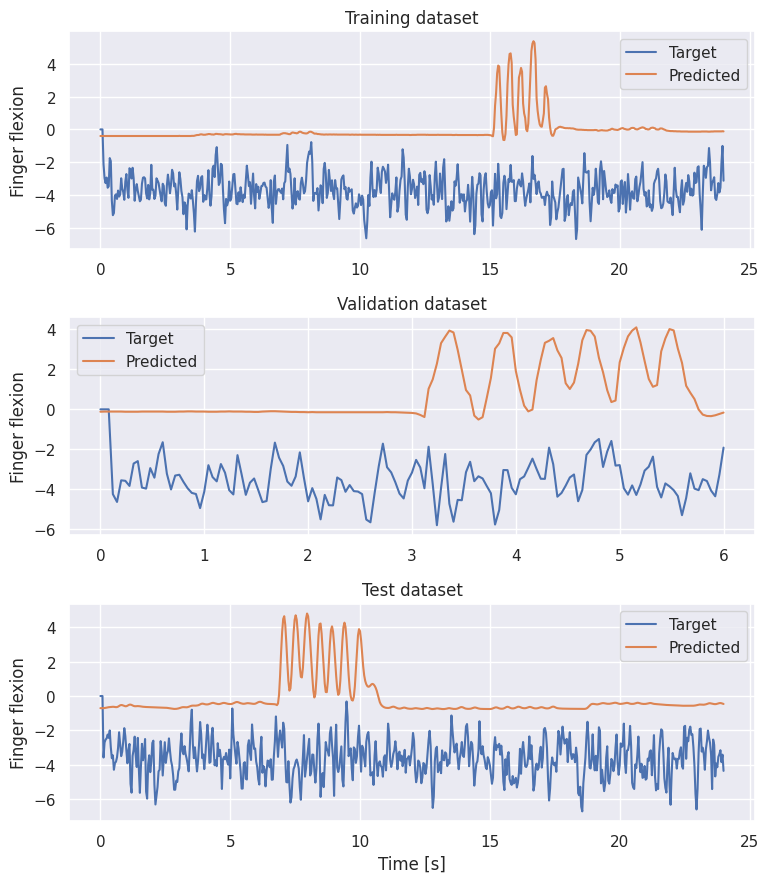

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Instead of using plt.style.use('seaborn'),
# apply Seaborn's style settings using sns.set_theme()
sns.set_theme(style="darkgrid")

# Now create your plots as usual

from matplotlib.lines import Line2D
import pandas as pd

# Remove the line below, it's causing the error:
# plt.style.use('seaborn')

fig, axes = plt.subplots(3, 1, figsize=(8, 9))

axes[0].set_title('Training dataset')
axes[0].plot(np.arange(y_train.shape[0]) / target_sfreq, y_train[:, 0], label='Target')
axes[0].plot(np.arange(preds_train.shape[0]) / target_sfreq, preds_train[:, 0],
             label='Predicted')
axes[0].set_ylabel('Finger flexion')
axes[0].legend()

axes[1].set_title('Validation dataset')
axes[1].plot(np.arange(y_valid.shape[0]) / target_sfreq, y_valid[:, 0], label='Target')
axes[1].plot(np.arange(preds_valid.shape[0]) / target_sfreq, preds_valid[:, 0],
             label='Predicted')
axes[1].set_ylabel('Finger flexion')
axes[1].legend()

axes[2].set_title('Test dataset')
axes[2].plot(np.arange(y_test.shape[0]) / target_sfreq, y_test[:, 0], label='Target')
axes[2].plot(np.arange(preds_test.shape[0]) / target_sfreq, preds_test[:, 0], label='Predicted')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('Finger flexion')
axes[2].legend()
plt.tight_layout()

In [ ]:
corr_coeffs = []
for dim in range(y_test.shape[1]):
    corr_coeffs.append(
        np.corrcoef(preds_test[:, dim], y_test[:, dim])[0, 1]
    )
print('Correlation coefficient for each dimension: ', np.round(corr_coeffs, 2))

Correlation coefficient for each dimension:  [0.04]
